In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Exercise 6

### The superconductivity dataset

The superconductivity dataset (Hamidieh, Computational Materials Science, 2018) contains $d=81$ chemical and molecular features extracted from 21263 superconductors along with the critical temperature (the label) in the last column. The goal is to predict the critical temperature from the features. If you are interested in the physical meaning of those, you can check out the original paper at https://arxiv.org/pdf/1803.10260.pdf

In the first part we will predict the critical temperature using least-square linear regression; in the second part we will train a neural network by gradient descent to predict the temperature.

## 0 Loading and pre-processing

Download the dataset from moodle or from `https://archive.ics.uci.edu/dataset/464/superconductivty+data` (24MB). The dataset we use is `train.csv` ; move it to the folder containing the notebook. In the following cell we load it. `data` contains the numerical values while `fields` of size $d+1$ is the name of the features.

In [2]:
fields = np.loadtxt("train.csv", delimiter=",", max_rows=1, dtype=str)
data = np.loadtxt("train.csv", delimiter=",", skiprows=1)

For each sample (each compound) the following features are given. The critical temperature we want to regress is the last one.

In [ ]:
print(fields)

**0.1** How many samples do we have ? What is the critical temperature of the 10th sample?

In [ ]:
# your answer

In [3]:
# solution
N, _ = data.shape
print(f"There are {N} samples.")
print(f"The critical temperature of the 10th sample is {data[10-1,-1]}.")

There are 21263 samples.
The critical temperature of the 10th sample is 31.0.


**0.2** `data` is of size $(N, d+1)$. The last column is the critical temperature. Extract it to form two numpy arrays : $y$ of size $(N,)$ containing the critical temperature and $X$ of size $(N,d)$ containing the remaining data.

In [ ]:
# your answer
y = 
X = 

In [4]:
# solution
X = data[:,:-1]
y = data[:,-1]

**0.3** Because the different features correspond to different physical quantities and have different units, thus different magnitudes of numerical values, we preprocess the arrays.

Compute $m_y$ the mean of $y$ and $\sigma_y$ its standard deviation. Then normalize and update $y$ accroding to $y\to (y-m_y)/\sigma_y$, where $y-m_y$ means that we substract the mean $m_y$ from each component of the vector $y$. Do the same for each column of $X$ i.e. for the mean of each feature across all datapoints. Use numpy functions and no `for` loop.

In [ ]:
# your answer
mY, stdY =
y =
X =

In [5]:
# solution
mY, stdY = np.mean(y), np.std(y)
y = (y-mY)/stdY
X = (X-np.mean(X, axis=0, keepdims=True))/np.std(X, axis=0, keepdims=True)

**0.4** Write a function `split` that given $X$ and $y$ returns a shuffled train, validation and test set with a 70%‑15%-15% split.

In [ ]:
# your answer
def split(X, y):
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
# solution
def split(X, y):
    indices = np.random.permutation(len(y))
    iTr = 7*len(y)//10
    iTe = 17*len(y)//20
    X_train = X[indices[:iTr]]
    y_train = y[indices[:iTr]]
    X_val = X[indices[iTr:iTe]]
    y_val = y[indices[iTr:iTe]]
    X_test = X[indices[iTe:]]
    y_test = y[indices[iTe:]]
    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = split(X, y)

## 1 Least-square linear regression

In this part we predict $y$ using least-square regression. More precisely we express our predictor $\hat{y}$ as a linear combination of the features $\hat{y}=Xw$ with $w\in\mathbb{R}^d$. We search for $w$ that minimizes the mean square error $L_\mathrm{train}$ between the predictions and the true values.
$$L_\mathrm{train}=\frac{1}{2}\frac{1}{\#\mathrm{train}}\sum_{n\in\mathrm{train}}(y_n-\hat{y}_n)^2 \qquad\qquad L_\mathrm{test}=\frac{1}{2}\frac{1}{\#\mathrm{test}}\sum_{n\in\mathrm{test}}(y_n-\hat{y}_n)^2$$


**1.1** Compute $w^*$ the minimizer of $L$ using the formula for the least-square estimator without regularization on the train set. Compute $\hat y_\mathrm{train}$ and $\hat y_\mathrm{test}$ the predicted values for the train and test sets. Compute and print the mean errors $L_\mathrm{train}$ and $L_\mathrm{test}$ you obtain with this estimator.

In [ ]:
# your answer
w = 
y_train_predicted = 
y_test_predicted = 

In [8]:
# solution
w = np.linalg.inv(X_train.T@X_train)@(X_train.T@y_train)
y_train_predicted = X_train@w
y_test_predicted = X_test@w
np.mean((y_train-y_train_predicted)**2)/2, np.mean((y_test-y_test_predicted)**2)/2

(0.1306107921301172, 0.13312545126817063)

**1.2** Plot the predicted temperature vs the true one for the samples from the test set. Use a scatter plot with small dots and add labels. Do not forget to rescale $y$ with $m_y$ and $\sigma_y$ to obtain physical temperatures. Plot the line $y=\hat y$.

In [ ]:
# your answer

Text(0, 0.5, '$\\hat y$')

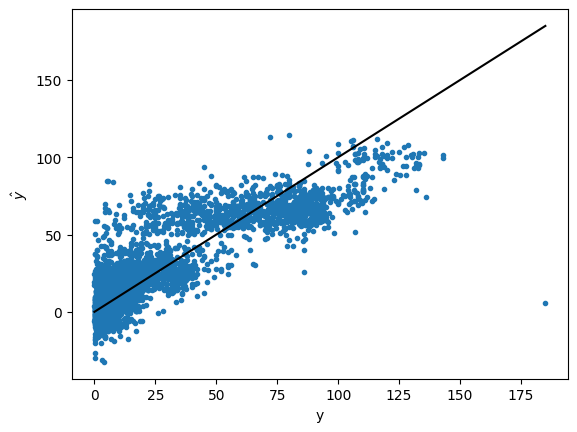

In [9]:
# solution
yT = y_test*stdY+mY
plt.scatter(yT, y_test_predicted*stdY+mY, marker='.')
plt.plot([min(yT),max(yT)], [min(yT),max(yT)], color="black")
plt.xlabel("y")
plt.ylabel(r"$\hat y$")

**1.3** In this case it is not required to add a regularization term on $w$ ; justify why.

*your answer*

*solution*

The problem is well overdetermined $N\approx 10^4\gg d\approx 10^2$ and the inverse of $X^TX$ is well defined.

## 2 Small neural network and gradient descent

One can construct better estimators by combining the columns of $X$ to create new features. For instance you already saw bits of polynomial features where we extend $X=(X_{i\mu})$ with powers of the data $X_{i\mu}^k$.

In this part we follow a different way. We let a neural network automatically constructs features from data, by combining it in a non-linear manner. We consider a simple neural network with two layers. Given data $X\in\mathbb{R}^{M\times d}$ it returns the prediction $\hat y\in\mathbb{R}^M$ defined by
$$
\hat y=f(X;W_1,W_2)=\sigma(XW_2+\mathrm{1_M}B^T)W_1
$$
where we set
* $W_1\in\mathbb{R}^p$ and $W_2\in\mathbb{R}^{d\times p}$ the two layers of weights,
* $B\in\mathbb{R}^p$ the biaises, $\mathrm{1_M}\in\mathbb{R}^M$ the vector full of ones, and $\mathrm{1_M}B^T$ is the matrix where each row is $B$,
* $p$ the number of hidden units,
* $\sigma$ is the activation function that acts element-wise on the matrix $XW_2+\mathrm{1_M}B^T$. We take $\sigma(x)=max(0,x)$.

We consider the same training loss as in the first part :
$$L_\mathrm{train}(W_1,W_2,B)=\frac{1}{2N'}\sum_{n=1}^{N'}(y_{\mathrm{train},n}-\hat y_{\mathrm{train},n})^2 \qquad\qquad \hat y_\mathrm{train}=f(X_\mathrm{train};W_1,W_2,B) \qquad\qquad N'=\#\mathrm{train}$$
We seek to minimize $L_\mathrm{train}$ with respect to $W_1$, $W_2$ and $B$. For this, we use gradient descent. The descent has to be done on the three sets of parameters $W_1$, $W_2$ and $B$ at the same time beause we want to minimize $L$ with respect to each of them.

**2.1** In the image classification tutorial you saw that one can use the logistic loss instead of the square loss, and that it is often more efficient. Why here do we prefer the quadratic loss ?

*your answer*

*solution*

We are doing regression and not classification : we want $\hat y$ to be as close as possible to $y$, and not just to have the same sign.

**2.2** We do gradient descent on the parameters $W_1$, $W_2$ and $B$, with a step size $\gamma$. We write $\nabla_{W_1}L\in\mathbb{R}^p$, $\nabla_{W_2}L\in\mathbb{R}^{d\times p}$ and $\nabla_{B}L\in\mathbb{R}^p$ the gradients of $L_\mathrm{train}$ with respect to them. We define the gradient of a function $g$ with respect to a vector $A$ or a matrix $C$ as the vector or the matrix of same dimensions with
$$
(\nabla_A g)_i = \frac{\partial g}{\partial A_i} \qquad\qquad (\nabla_C g)_{ij} = \frac{\partial g}{\partial C_{ij}}\ .
$$
Given $W_1^{(t)}$, $W_2^{(t)}$ and $B^{(t)}$ the values of $W_1$, $W_2$ and $B$ at iteration $t$ of gradient descent, write down their values $W_1^{(t+1)}$, $W_2^{(t+1)}$ and $B^{(t+1)}$ at the next iteration (one line for each).

*your answer*

*solution*

$$W_1^{(t+1)} = W_1^{(t)} - \gamma \nabla_{W_1}L(W_1^{(t)},W_2^{(t)},B^{(t)})$$
$$W_2^{(t+1)} = W_2^{(t)} - \gamma \nabla_{W_2}L(W_1^{(t)},W_2^{(t)},B^{(t)})$$
$$B^{(t+1)} = B^{(t)} - \gamma \nabla_BL(W_1^{(t)},W_2^{(t)},B^{(t)})$$

**2.3** We use the chain rule to compute $\nabla_{W_1}L$, $\nabla_{W_2}L$ and $\nabla_BL$. It states that
$$
\nabla_{W_1}L = (\nabla_{\hat y_\mathrm{train}}L)^T\nabla_{W_1}f \qquad\qquad \nabla_{W_2}L = (\nabla_{\hat y_\mathrm{train}}L)^T\nabla_{W_2}f \qquad\qquad \nabla_BL = (\nabla_{\hat y_\mathrm{train}}L)^T\nabla_Bf
$$
with $\nabla_{W_1}f\in\mathbb{R}^{N'\times p}$, $\nabla_{W_2}f\in\mathbb{R}^{N'\times d\times p}$ and $\nabla_Bf\in\mathbb{R}^{N'\times p}$ the gradients of $f$ with respect to $W_1$, $W_2$ and $B$.

$\nabla_{\hat y_\mathrm{train}}L$ is the gradient of $L_\mathrm{train}$ with respect to $\hat y_\mathrm{train}$. Show in two lines that $\nabla_{\hat y_\mathrm{train}}L=(\hat y_\mathrm{train}-y_\mathrm{train})/N'$. Compute $\nabla_{W_1}f$ and then $\nabla_{W_1}L$.

*your answer*

*solution*

$$\frac{\partial L_\mathrm{train}}{\partial\hat y_{\mathrm{train},n}}=\frac{1}{N'}(\hat y_\mathrm{train}-y_\mathrm{train})_n$$
hence the solution. For $W_1$ we have
$$\nabla_{W_1}f = \sigma(X_\mathrm{train}W_2+\mathrm{1}_MB^T)$$
and then
$$\nabla_{W_1}L = \frac{1}{N'}(\hat y_\mathrm{train}-y_\mathrm{train})^T\sigma(X_\mathrm{train}W_2+\mathrm{1}_MB^T)$$

**2.4** We give an implementation of $\nabla_{W_2}L$ and $\nabla_BL$. Implement functions that compute $\sigma$, $\sigma'$, $f$, $L$ and $\nabla_{W_1}L$. They should be vectorized to be fast enough.

In [ ]:
# your answer
def sigma(x):
    """
    activation function
    """
    return 

def deriv_sigma(x):
    """
    derivative of the activation function
    """
    return 

def neural_net(X,W_1,W_2,B): 
    """
    function implementing the neural network f
    W_1 is a (p,) array
    W_2 is a (d, p) array
    B is a (p,) array
    X is a (n, d) array
    """
    return 

def loss(y,z):
    """
    quadratic loss
    y and z are (n,) arrays
    """
    return 

def grad_W_1(X,W_1,W_2,B,y):
    """
    gradient of the loss with respect to W_1
    """
    return
    
def grad_W_2(X,W_1,W_2,B,y):
    """
    gradient of the loss with respect to W_2
    """
    pre_activations=X@W_2+B
    z=sigma(pre_activations)@W_1
    return np.einsum('n,p,np,nd->dp', z-y, W_1, deriv_sigma(pre_activations), X)/len(y)

def grad_B(X,W_1,W_2,B,y):
    """
    gradient of the loss with respect to B
    """
    pre_activations=X@W_2+B
    z=sigma(pre_activations)@W_1
    return (z-y)@(deriv_sigma(pre_activations)*W_1)/len(y)

In [10]:
# solution
def sigma(x):
    """
    activation function
    """
    return x*(x>0)

def deriv_sigma(x):
    """
    derivative of the activation function
    """
    return 1.*(x>0)

def neural_net(X,W_1,W_2,B): 
    """
    function implementing the neural network f
    W_1 is a (p,) array
    W_2 is a (d, p) array
    B is a (p,) array
    X is a (n, d) array
    """
    return sigma(X@W_2+B)@W_1

def loss(y,z):
    """
    quadratic loss
    y and z are (n,) arrays
    """
    return (z-y)**2/2

def grad_W_1(X,W_1,W_2,B,y):
    """
    gradient of the loss with respect to W_1
    """
    post_activations=sigma(X@W_2+B)
    z=post_activations@W_1
    return (z-y)@post_activations/len(y)
    
def grad_W_2(X,W_1,W_2,B,y):
    """
    gradient of the loss with respect to W_2
    """
    pre_activations=X@W_2+B
    z=sigma(pre_activations)@W_1
    return np.einsum('n,p,np,nd->dp', z-y, W_1, deriv_sigma(pre_activations), X)/len(y)

def grad_B(X,W_1,W_2,B,y):
    """
    gradient of the loss with respect to B
    """
    pre_activations=X@W_2+B
    z=sigma(pre_activations)@W_1
    return (z-y)@(deriv_sigma(pre_activations)*W_1)/len(y)

**2.5** Implement the gradient descent. You shall :
* compute and save the value of the train loss at each iteration ; same for the validation loss ;
* stop the gradient descent after a fixed well-chosen number $t_\mathrm{max}$ of iterations ;
* plot the train and validation losses with labels and a legend, using a log-log scale ;
* tune $\gamma$ to obtain good results with reasonable computing time. Remember that large $\gamma$ is unstable and small $\gamma$ is slow.

You should :
* start from weights randomly initialised, each component of $W_1$ as a Gaussian with zero mean and variance 1 and each component of $W_2$ as a Gaussian with zero mean and variance $1/d$. Take $B$ all zeros ;
* take $p=5$ ;
* check that the train loss decreases ;
* while debugging your code take $t_\mathrm{max}$ not too large. Once it runs correctly take a larger $t_\mathrm{max}$ to obtain a better test loss.

In [ ]:
# your answer
tMax=
p=5
gamma=
W_1=
W_2=
B=
train_losses=[]
val_losses=[]


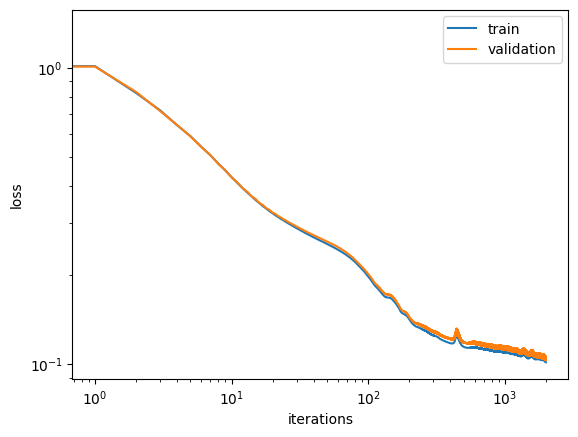

In [11]:
# solution
d = X.shape[1]
tMax=2000
p=5
gamma=0.03
W_1=np.random.normal(size=(p,))
W_2=np.random.normal(size=(d,p))/np.sqrt(d)
B=np.zeros(p)

train_losses=[]
val_losses=[]

for t in range(tMax):
    y_pred_train=neural_net(X_train,W_1,W_2,B)
    train_losses.append(np.mean(loss(y_pred_train,y_train)))
    y_pred_val=neural_net(X_val,W_1,W_2,B)
    val_losses.append(np.mean(loss(y_pred_val,y_val)))
    
    W_1, W_2, B = W_1-gamma*grad_W_1(X_train, W_1, W_2, B, y_train), \
                    W_2-gamma*grad_W_2(X_train, W_1, W_2, B, y_train), \
                    B-gamma*grad_B(X_train, W_1, W_2, B, y_train)

plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("loss")
plt.xscale('log')
plt.yscale('log')

**2.6** Once we have optimized the training compute the test loss of the trained model and print it. In this case does the model overfit ?

In [ ]:
# your answer

In [12]:
# solution
y_pred_test=neural_net(X_test,W_1,W_2,B)
test_loss = np.mean(loss(y_pred_test,y_test))
print(test_loss)

0.10298384587789484


*solution*

There is little overfitting since after training the train, validation and test losses are close. The small variations between the three are mainly due to the random split.

**2.7** Using your trained neural network predict the temperature of the 10th sample of the test set and compare to the true value.

In [ ]:
# your answer

In [13]:
# solution
print(y_pred_test[10-1]*stdY+mY, y_test[10-1]*stdY+mY)

106.22899121404471 126.6
